In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from constants import SimConstants as sconst
from constants import Environment as env

## Analysis

In [36]:
data_csv = pd.read_csv('./data/data.csv')
data_csv

,position_x,position_y,velocity_x,velocity_y,force_x,force_y,pressure,person_state
0,44.500000,17.500000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,8.500000,11.500000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,20.500000,21.500000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,17.500000,23.500000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,69.500000,34.500000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
999995,67.524413,15.436859,6.286170,0.669587,0.0,0.0,0.0,1.0
999996,67.535714,26.979399,5.045209,-1.656765,0.0,0.0,0.0,1.0
999997,67.523741,17.198394,5.457386,0.309082,0.0,0.0,0.0,1.0
999998,67.537143,22.127441,6.133929,-0.635108,0.0,0.0,0.0,1.0


In [37]:
data_arr = data_csv.to_numpy()
data = data_arr.reshape(sconst.n_time_steps, -1, *data_arr.shape[1:])
print(data.shape)

(1000, 1000, 8)


Text(0.5, 0, 'Time [s]')

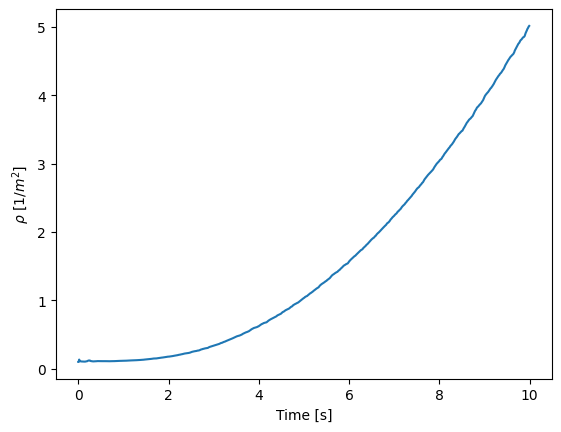

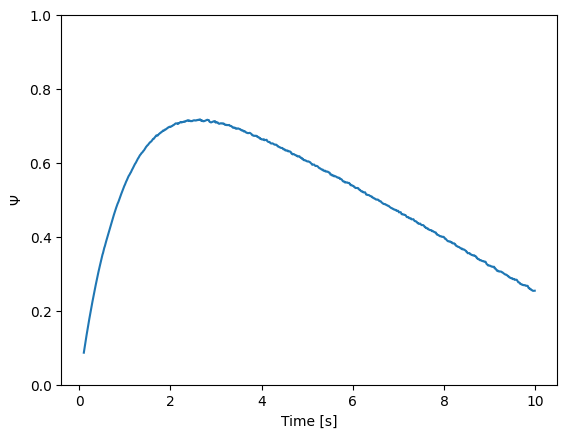

In [38]:
%matplotlib inline

avg_densities = np.zeros(sconst.n_time_steps)
allign_coefs = np.zeros(sconst.n_time_steps)

for t in range(sconst.n_time_steps):
    positions = data[t, :, 0:2]
    velocities = data[t, :, 2:4]
    forces = data[t, :, 4:6]
    pressures = data[t, :, 6]
    person_state = data[t, :, 7]

    velocities[person_state > 0] = 0
    
    counts = np.zeros(sconst.n_individuals)
    
    mean_velocity = np.linalg.norm(np.mean(velocities, axis=0))+0.000000001
    sum_velocity = np.sum(velocities/sconst.v_max, axis=0)
    allign_coefs[t] = np.linalg.norm(sum_velocity)
    
    for i in range(sconst.n_individuals):
        circle_rad = 1
        circle_area = circle_rad*np.pi*np.pi
        distances = np.linalg.norm(positions[i] - positions, axis=1)
        counts[i] = np.sum(distances < circle_rad)

    avg_densities[t] = np.mean(counts)/circle_area
    
allign_coefs /= sconst.n_individuals
        
time_steps = np.arange(sconst.n_time_steps)
        
fig = plt.figure()
plt.plot(time_steps * sconst.time_inc, avg_densities)
plt.xlabel("Time [s]")
plt.ylabel(r"$\rho \ [1/m^2]$")

fig = plt.figure()
plt.plot(time_steps[10:] * sconst.time_inc, allign_coefs[10:])
plt.ylim((0,1))
plt.ylabel(r"$\Psi$")
plt.xlabel("Time [s]")

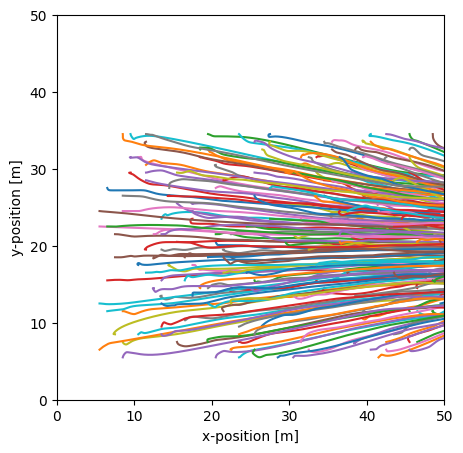

In [39]:
fig = plt.figure(figsize=(5,5))
plt.xlim(0, sconst.max_pos[0])
plt.ylim(0, sconst.max_pos[1])
particles = np.arange(300)

plt.xlabel("x-position [m]")
plt.ylabel("y-position [m]")
plt.plot(data[:, particles, 0], data[:, particles, 1]);

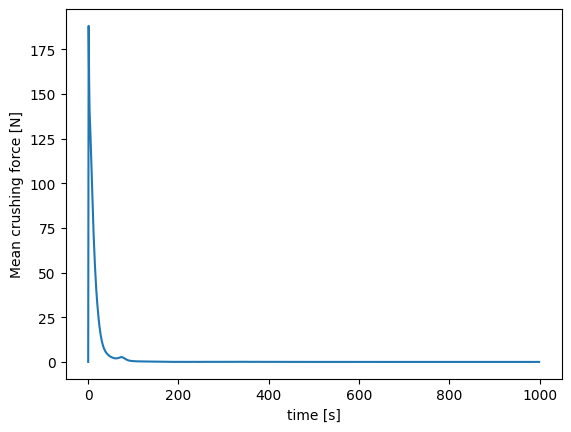

In [40]:
living_states = data[:, :, 7]
pressures = data[living_states==0, 6]
fig = plt.figure()
plt.xlabel("time [s]")
plt.ylabel("Mean crushing force [N]")
plt.plot(time_steps, np.mean(data[:, :, 6], axis=1));

(1000, 1000)


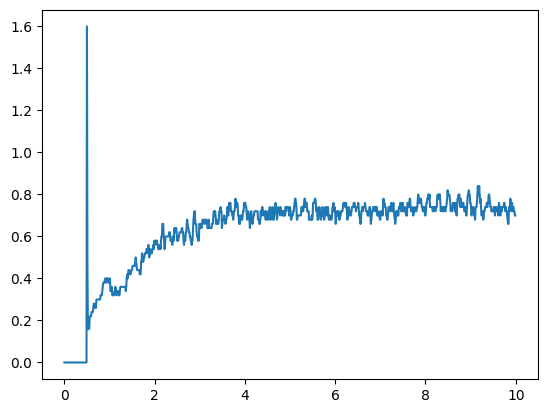

In [41]:
# Number of people leaving as a function of time
living_states = data[:, :, 7]
n_leaving = (living_states == 1).astype(int)
print(n_leaving.shape)
n_leaving_t = n_leaving[1:] - n_leaving[:-1]

n_frames = sconst.n_time_steps
avg_window = 50
n_leaving_t_avg = np.zeros(n_frames)
n_left = np.sum(n_leaving_t, axis=1)
for i in range(avg_window, n_frames):
    window = n_left[i-avg_window:i]
    n_leaving_t_avg[i] = np.mean(window)

plt.plot(np.arange(1000)*sconst.time_inc, n_leaving_t_avg);

C:\Users\gaspa\AppData\Local\Temp\ipykernel_9260\3378662099.py:3: RuntimeWarning: divide by zero encountered in true_divide
  reynold = avg_densities * sconst.v_max * (env.right_inner - env.left_inner) / n_leaving_t_avg


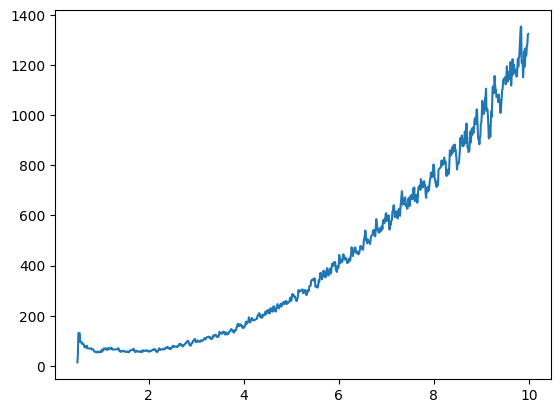

In [43]:
# Reynolds number
#reynold = np.zeros(sconst.n_time_steps)
reynold = avg_densities * sconst.v_max * (env.right_inner - env.left_inner) / n_leaving_t_avg
plt.plot(np.arange(sconst.n_time_steps)*sconst.time_inc, reynold)

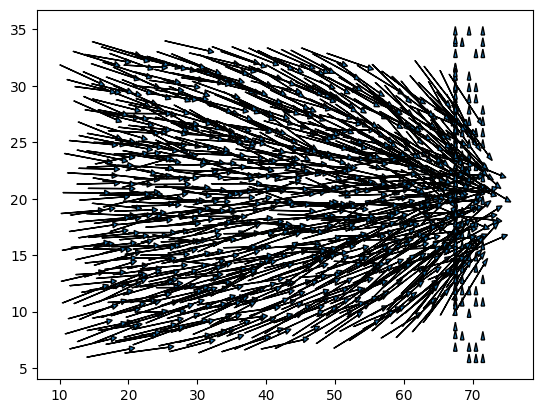

In [74]:


frame = 200

pos_info = data[frame, :, :4]
fig = plt.figure()
ax = fig.gca()
arrow_len = 1.5
for i in range(sconst.n_individuals):
    ax.arrow(pos_info[i, 0], pos_info[i, 1], arrow_len*pos_info[i, 2], arrow_len*pos_info[i, 3], head_width=0.5)
#plt.streamplot(pos_info[unique_xs, 0], pos_info[:, 1], pos_info[:, 2], pos_info[:, 3])



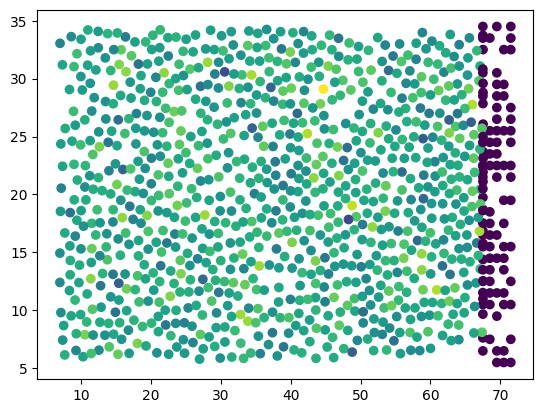

interactive(children=(IntSlider(value=100, description='frame', max=1000), Output()), _dom_classes=('widget-in…

In [91]:
from ipywidgets import interact, interactive

fig = plt.figure()
pos_info = data[100, :, :4]
im = plt.scatter(pos_info[:, 0], pos_info[:, 1], c=np.linalg.norm(pos_info[:, 2:4], axis=1))



@interact(frame=(0, 1000))
def vel_density(frame=100):
    pos_info = data[frame, :, :4]

    im = plt.scatter(pos_info[:, 0], pos_info[:, 1], c=np.linalg.norm(pos_info[:, 2:4], axis=1))
    plt.colorbar(im)

